# Overview and Notes

What are interesting scenarios for exploring correlations?
* Expression-dependency correlations for dependency genes that are druggable. For these, the expression correlates are informative for selection of sensitive cell lines/patients. In addition, causally related expression correlates are suggestive of possible resistance mechanisms or secondary targets for a drug combination.
* Dependency-dependency correlations for undruggable genes. For these, the correlates are suggestive of substitute targets, or combinations of targets. However, as combinations are considered the causal interpretation becomes more important.
* Expression-expression correlations. In this case one idea would be to explore the strength and sign of relationships from the data vs. assertions from curated databases/literature, particularly from perturbational experiments.
* Co-expression patterns. Another possibility is to discover patterns of relationships between genes, e.g. that expression of ubiquitin ligases is correlated with the expression of their targets.

Another interesting direction would be to use the information in the INDRA database to discover patterns of mechanistic relationships that predict correlations between dependencies of two genes, or between expression of a gene and dependency of another gene. The simplest possible application of this would be to look at pairwise relationships between two genes (could even extract from SIF), and test to see which types of relationships, and signs of relationships predicted, and amount of evidence predicted a) the sign of a correlation and b) the strength of the correlation.

If the matrix is made complete, i.e., if entries are included for having no known relationship, we may find that having no relationship is not predictive of a lack of a correlation.

Similarly, there will be many mechanistic relationships that yield detectable correlations.

One hypothesis that could be tested is whether downstream siblings were more likely to have large correlations to each other than with their ancestors, highlighting that correlations rarely pick up causal relations in this type of data.

Could do this with graph convolutional nets?

Another application would be to use the data to refine vague relationships extracted from text, or to address issues with assembly, a la distant supervision.

Another direction would be to cluster the correlation graph to find likely intermediates.

Or, to use the redundancy of certain gene families to explain why certain correlations do *not* show up, i.e., the gene knockout has no effect because it has a redundant copy.

# Preliminaries

In [3]:
import pickle
from os.path import join, expanduser
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from indra.databases import hgnc_client
from indra.tools import assemble_corpus as ac
%matplotlib notebook

## Load transcript and dependency data and compute correlations


Key variables/functions:
* `ccle_df`. CCLE expression data, DataFrame.
* `crispr_df`. DepMap CRISPR gene effect (dependency) data, DataFrame.
* `crispr_corr`
* `crispr_z`
* `rnai_df`. DepMap combined RNAi data, DataFrame.
* `rna_corr`
* `rnai_z`
* `dep_z`
* `dep_df`. CRISPR and RNAi data combined as averaged z-scores, DataFrame.
* `dep_corr`. Correlation matrix between dep-dep, dep-expr, and expr-expr (though expr-expr correlations are only defined in this matrix for the genes also included in the dependency data).

### Working directory

In [4]:
basedir = 'data/19q4'
figdir = join(expanduser('~'), 'Dropbox/DARPA projects/papers/INDRA paper 2/figures/figure_panels')

### Cell line metadata

Load the cell line metadata which includes mappings between cell line identifiers used by different datasets.

In [5]:
cell_line_df = pd.read_csv(join(basedir, 'sample_info.csv'))
#cell_line_df = pd.read_csv('data/DepMap-2019q1-celllines_v2.csv')

In [6]:
cell_line_map = cell_line_df[['DepMap_ID', 'CCLE_Name']]
cell_line_map.set_index('CCLE_Name', inplace=True)
cell_line_map.head()

,DepMap_ID
CCLE_Name,
NIHOVCAR3_OVARY,ACH-000001
HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000002
CACO2_LARGE_INTESTINE,ACH-000003
HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000004
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000005


### RNAi data

Load combined RNAi data, normalize column names, map to DepMap cell line IDs, and drop duplicate columns.

In [7]:
%time rnai_df = pd.read_csv(join(basedir, 'D2_combined_gene_dep_scores.csv'), index_col=0)
rnai_df = rnai_df.transpose()
gene_cols = ['%s' % col.split(' ')[0] for col in rnai_df.columns]
rnai_df.columns = gene_cols
rnai_df = rnai_df.join(cell_line_map)
rnai_df = rnai_df.set_index('DepMap_ID')
# Drop duplicate columns
rnai_df = rnai_df.loc[:,~rnai_df.columns.duplicated()]

CPU times: user 2.05 s, sys: 200 ms, total: 2.25 s
Wall time: 2.27 s


In [8]:
rnai_df.head()

,A1BG,NAT2,ADA,CDH2,AKT3,MED6,NR2E3,NAALAD2,DUXB,PDZK1P1,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,KCNE2,DGCR2,CASP8AP2,SCO2
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-001270,NaN,NaN,NaN,-0.194962,-0.256108,-0.174220,-0.140052,NaN,NaN,NaN,...,-0.201644,-0.363670,0.184260,-0.115616,-0.125958,NaN,0.088853,NaN,-0.843295,NaN
ACH-001000,NaN,NaN,NaN,-0.028171,0.100751,-0.456124,-0.174618,NaN,NaN,NaN,...,0.074889,0.152158,0.036011,0.117300,0.101725,NaN,-0.110628,NaN,-0.307031,NaN
ACH-001001,0.146042,0.102854,0.168839,0.063047,-0.008077,-0.214376,-0.153619,0.133830,0.138673,0.030345,...,0.006735,-0.033385,0.197651,-0.016372,0.077486,0.106165,0.057286,0.025596,-0.413669,0.122669
ACH-002319,-0.190388,0.384106,-0.120700,-0.237251,0.060267,-0.338946,-0.057551,0.134511,NaN,0.144463,...,0.209009,-0.156839,-0.155837,-0.001141,NaN,0.227968,0.028095,-0.080611,-1.849696,-0.078856
ACH-001827,0.907063,0.403192,0.004394,-0.017059,-0.094749,-0.328074,-0.089573,0.362029,NaN,-0.098161,...,-0.137465,-1.037848,-0.261262,-0.228016,NaN,0.088744,0.159467,0.014071,-0.414154,0.032661


In [9]:
recalculate = False
filename = 'rnai_correlations'
filepath = join(basedir, filename)
if recalculate:
    %time rnai_corr = rnai_df.corr()
    rnai_corr.to_hdf('%s.h5' % filepath, filename)
else:
    rnai_corr = pd.read_hdf('%s.h5' % filepath)

INFO: [2020-08-03 13:48:01] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2020-08-03 13:48:01] numexpr.utils - NumExpr defaulting to 8 threads.


In [10]:
rnai_mean = rnai_corr.values.mean()
rnai_sd = rnai_corr.values.std()
rnai_z = (rnai_corr - rnai_mean) / rnai_sd

In [11]:
rnai_z.head()

,A1BG,NAT2,ADA,CDH2,AKT3,MED6,NR2E3,NAALAD2,DUXB,PDZK1P1,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,KCNE2,DGCR2,CASP8AP2,SCO2
A1BG,12.735562,-0.770498,-0.828444,0.593730,-0.334519,-0.076705,1.054949,0.591804,0.385034,-0.120219,...,1.446480,-1.964996,-0.403560,0.402625,-0.396057,0.131028,0.227373,-0.701314,0.218191,1.198913
NAT2,-0.770498,12.735562,0.572062,-0.052426,-0.528069,0.307443,-0.021474,-0.590996,-0.318764,-1.449979,...,0.371740,-0.754718,0.017751,0.024919,-2.128375,-0.190518,0.608389,-0.842078,-1.303389,-0.503340
ADA,-0.828444,0.572062,12.735562,-0.451619,-0.577117,0.422290,-0.188984,-0.570248,-0.078767,0.119471,...,0.475397,0.045575,0.639884,0.858577,-0.315503,-0.353140,-0.704099,1.271989,0.150168,-0.217580
CDH2,0.593730,-0.052426,-0.451619,12.735562,0.565031,-0.946426,-0.135411,0.118138,0.201983,-0.383189,...,-0.570892,-1.780034,1.163082,-1.070628,-0.127555,-0.228329,0.010906,-1.423871,-1.132664,-0.382607
AKT3,-0.334519,-0.528069,-0.577117,0.565031,12.735562,-0.378659,-1.136175,0.590426,0.837794,-0.574912,...,-1.262663,0.259384,0.443690,-0.919940,0.283450,-1.192266,-0.581840,-1.243842,-0.184748,-0.345918


### CRISPR Data

Load CRISPR dependency data and normalize column names to gene names.

In [12]:
%time crispr_df = pd.read_csv(join(basedir, 'Achilles_gene_effect.csv'), index_col=0)
gene_cols = ['%s' % col.split(' ')[0] for col in crispr_df.columns]
crispr_df.columns = gene_cols
# Drop any duplicate columns (shouldn't be any for CRISPR, but just in case)
crispr_df = crispr_df.loc[:,~crispr_df.columns.duplicated()]

CPU times: user 10.5 s, sys: 365 ms, total: 10.9 s
Wall time: 11 s


In [13]:
crispr_df.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
ACH-000004,0.175458,0.088569,-0.200480,-0.011510,0.038665,-0.179569,0.346621,-0.436619,0.296611,0.156186,...,-0.128622,-0.465613,NaN,NaN,0.256600,0.233192,-0.407076,0.290238,0.231701,-0.131914
ACH-000005,-0.075851,0.238834,0.186692,0.173939,-0.195703,-0.334521,0.261907,-0.565825,-0.069894,0.017819,...,-0.188845,-0.407702,-0.167827,-0.105463,0.201881,-0.087856,-0.087936,0.051749,0.017164,-0.237130
ACH-000007,0.065688,0.081300,-0.062100,0.156060,0.090242,0.151455,0.058420,-0.465499,-0.011669,0.285222,...,-0.101191,-0.277256,-0.041516,0.115520,0.216589,-0.013638,-0.346116,0.081862,-0.398021,-0.437610
ACH-000009,0.069153,-0.010769,-0.055937,0.065006,0.033323,0.041139,0.016064,-0.628483,0.167551,0.037239,...,-0.348522,-0.286323,-0.031556,0.116820,0.115633,0.039425,-0.582022,0.235893,-0.114144,-0.552371
ACH-000011,0.283072,0.079233,0.004812,0.435606,-0.036532,-0.256236,0.104737,-0.426808,0.133284,0.110128,...,-0.420476,-0.512808,-0.137283,-0.134316,0.271370,0.151674,-0.236025,0.115031,-0.260451,-0.396218


In [14]:
# Filter out this problematic outlier stomach cell line
crispr_df = crispr_df[crispr_df.index != 'ACH-000167']

In [15]:
recalculate = False
filename = 'crispr_correlations'
filepath = join(basedir, filename)
if recalculate:
    %time crispr_corr = crispr_df.corr()
    crispr_corr.to_hdf('%s.h5' % filepath, filename)
else:
    crispr_corr = pd.read_hdf('%s.h5' % filepath)    

In [16]:
crispr_mean = crispr_corr.values.mean()
crispr_sd = crispr_corr.values.std()
crispr_z = (crispr_corr - crispr_mean) / crispr_sd

In [17]:
crispr_z.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A1BG,17.386862,-1.611587,1.537125,-0.371831,0.675404,0.806532,0.890930,0.124887,-0.152094,-0.049661,...,1.150722,-0.278224,-1.351132,-1.195514,-1.391803,1.249488,0.637170,0.760998,1.000422,-0.208967
A1CF,-1.611587,17.386862,0.099918,0.225800,-0.363240,-1.978543,0.421315,0.866758,-1.473701,0.300807,...,-1.926029,0.092970,1.292896,1.145430,-0.848040,-0.442390,0.865043,-0.507596,0.409119,0.493634
A2M,1.537125,0.099918,17.386862,2.444142,0.023278,-1.717658,-0.335334,-0.741835,-0.101217,0.648739,...,0.088884,-0.446254,-1.323501,-1.367175,0.400456,0.013602,-0.161717,-0.211830,0.418842,-0.481444
A2ML1,-0.371831,0.225800,2.444142,17.386862,-1.082400,-0.971954,-0.984631,-0.943763,0.013231,-0.499638,...,-2.781609,-1.725450,-0.892022,-0.042109,-0.323282,0.617690,0.072703,0.551272,-1.075228,-0.862648
A3GALT2,0.675404,-0.363240,0.023278,-1.082400,17.386862,-0.618235,-0.302641,-0.979399,-0.773458,0.995580,...,-0.174611,0.046370,-0.499677,-0.671568,-2.302793,0.412390,0.910653,0.249479,-0.454204,0.439872


### Combine CRISPR and RNAi Z-scores

Take the average of CRISPR and RNAi z-scores and drop missing values (that arise from a gene being knocked down/out in one dataset but not the other).

In [18]:
dep_z = (crispr_z + rnai_z) / 2
dep_z = dep_z.dropna(axis=0, how='all').dropna(axis=1, how='all')

In [19]:
dep_z.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYX,ZZEF1,ZZZ3
A1BG,15.061212,-1.254244,0.589411,-0.429601,0.316854,0.517943,0.315727,-0.699488,0.124678,0.254488,...,0.587929,1.345790,-0.566663,-0.613617,-0.837744,-0.840396,0.800496,0.249685,0.385701,-0.358872
A1CF,-1.254244,15.061212,-0.112276,0.719419,-1.314685,0.446881,0.963925,-0.434793,0.693063,-0.254416,...,0.553517,-1.621843,-0.211439,0.332445,0.737837,-0.155204,0.555388,0.333483,-0.236818,-0.273413
A2M,0.589411,-0.112276,15.061212,0.441633,-1.252345,0.333756,-0.568171,-0.788586,-0.355503,0.947149,...,0.124226,-0.526018,0.013798,-1.277596,-0.324378,-0.753189,-0.014604,-0.118126,0.180529,-0.994985
A2ML1,-0.429601,0.719419,0.441633,15.061212,-0.255206,-0.511601,0.024782,0.508125,0.396726,0.442482,...,-0.763110,-1.396749,-0.823833,0.259510,-0.417436,-0.094510,0.222123,-0.091210,-0.920968,-0.957413
A4GALT,0.316854,-1.314685,-1.252345,-0.255206,15.061212,-0.421909,0.838193,-0.480847,0.326498,1.460646,...,0.198601,0.221719,-0.389450,0.693024,-0.620295,0.569642,0.418810,0.653991,-0.731775,0.211079


In [20]:
filename = 'dep_z'
filepath = join(basedir, filename)
dep_z.to_hdf('%s.h5' % filepath, filename)

### Expression Data

Load the RNA-seq data (in transcripts per million, obtained from the DepMap website at https://depmap.org/portal/download/). Normalize column names (which include both gene names and Ensemble IDs) to only gene names, and then drop duplicate columns, keeping the first instance of the column for the gene name (there are 87 genes associated with more than one Ensemble ID, and these result in duplicate columns after normalizing to gene names).

In [21]:
%time ccle_df = pd.read_csv(join(basedir, 'CCLE_expression.csv'), index_col=0)

CPU times: user 21.2 s, sys: 865 ms, total: 22.1 s
Wall time: 22.4 s


In [22]:
gene_cols = ['%s' % col.split(' ')[0] for col in ccle_df.columns]
ccle_df.columns = gene_cols
# NOTE: This first way doesn't work! Probably because with duplicate column names a
# separate integer index is created after transposition (?)
#%time ccle_df_drop = ccle_df.T.drop_duplicates(keep='first').T
# See: https://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
ccle_df_drop = ccle_df.loc[:,~ccle_df.columns.duplicated()]

Filter the expression data to contain only those columns also contained in the CRISPR dependency data (protein coding genes, for the most part).

In [23]:
crispr_cols = [c for c in crispr_df.columns]
# Create a boolean mask to filter the CCLE expression data columns
ccle_col_mask = np.array(ccle_df_drop.columns.map(lambda x: x in crispr_cols), dtype=bool)
ccle_df_filt = ccle_df_drop[ccle_df_drop.columns[ccle_col_mask]]

Join the two datasets on the cell line index:

In [24]:
crispr_expr_join_df = crispr_df.join(ccle_df_filt, how='left', lsuffix=' KO', rsuffix=' RNA')

Calculate the correlations (slow) or reload from HDF5.

In [33]:
recalculate = False
filename = 'dep_expr_correlations'
filepath = join(basedir, filename)
if recalculate:
    %time corr = crispr_expr_join_df.corr()
    corr.to_hdf('%s.h5' % filepath, filename)
else:
    corr = pd.read_hdf('%s.h5' % filepath)

### Load Drug Data

In [25]:
drug_resp_df = pd.read_csv(join(basedir, 'primary-screen-replicate-collapsed-logfold-change.csv'), index_col=0)
drug_info_df = pd.read_csv(join(basedir, 'primary-screen-replicate-collapsed-treatment-info.csv'), index_col=0)

Join drug sensitivity to expression on the cell line index:

In [26]:
drug_expr_df = drug_resp_df.join(ccle_df_filt, how='left')

## Load INDRA DB Directed Graph

In [36]:
with open(join(basedir, 'indranet_dir_graph_latest.pkl'), 'rb') as f:
    indra_dg = pickle.load(f)

## Define functions for exploring and visualizing the data

Get the sorted list of correlations for a given gene.

In [27]:
def sort_corrs(corrs, col_name):
    s = corrs[col_name]
    return sorted(list(zip(s.index, s)), key=lambda x: abs(float(x[1])), reverse=True)

Define a function to get the top correlated genes for a given gene.

In [28]:
def get_expr_corrs(df, geneX):
    mygene_arr = df[geneX].values
    data = df.values
    corrs = np.zeros(data.shape[1])
    for i in range(data.shape[1]):
        vect = data[:,i]
        r = np.corrcoef(mygene_arr, vect)[0, 1]
        corrs[i] = r
    genes = [c for c in df.columns]
    corr_genes = sorted(list(zip(genes, corrs)), reverse=True, key=lambda x: abs(x[1]))
    corr_genes_dict = {k: v for k, v in corr_genes}
    return corr_genes

In [29]:
def corrs_for_genes(genes, cutoff=3.0):
    all_corrs = []
    for gene_a in genes:
        try:
            gene_corrs = sort_corrs(dep_z, gene_a)[1:]
        except KeyError:
            continue
        for gene_b, corr_z in gene_corrs:
            if abs(corr_z > cutoff):
                all_corrs.append((gene_a, gene_b, corr_z))
    return all_corrs

Define a function to plot the relationship between the transcription of two genes, along with a linear regression and the residuals.

In [30]:
def scatter(df, geneX, y_arr, y_label, bins=30):
    plt.figure(figsize=(12,3))
    plt.subplot(1, 3, 1)
    plt.plot(df[geneX], y_arr, linestyle='', marker='.')
    plt.xlabel('%s TPM' % geneX)
    plt.ylabel(y_label)
    r = np.corrcoef(df[geneX], y_arr)[0][1]
    plt.title('Corr: %.3f' % r)
    slope, intercept, r_value, p_value, std_err = \
                    stats.linregress(df[geneX], y_arr)
    yhat = slope * df[geneX] + intercept
    plt.plot(df[geneX], yhat, color='k')
    residuals = y_arr - yhat
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=bins)
    plt.title('Residuals')
    plt.subplot(1, 3, 3)
    stats.probplot(residuals, dist='norm', plot=plt)
    plt.title('Quantile-quantile plot vs. normal')
    return residuals

<IPython.core.display.Javascript object>


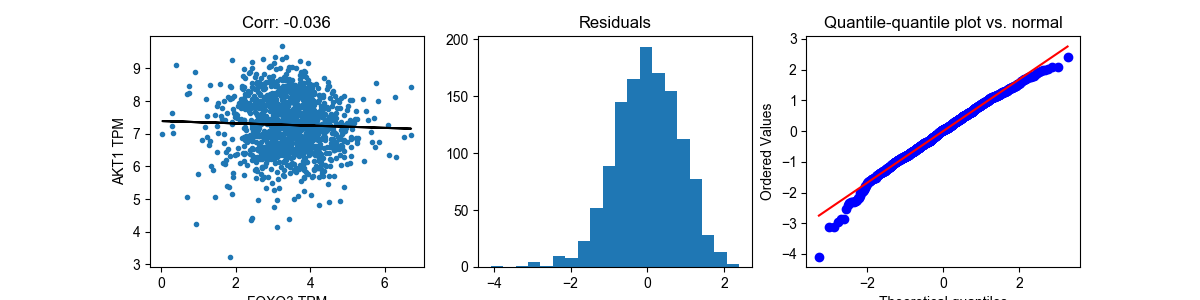

In [31]:
res1 = scatter(ccle_df, 'FOXO3', ccle_df['BAX'], 'AKT1 TPM', bins=20)

<IPython.core.display.Javascript object>


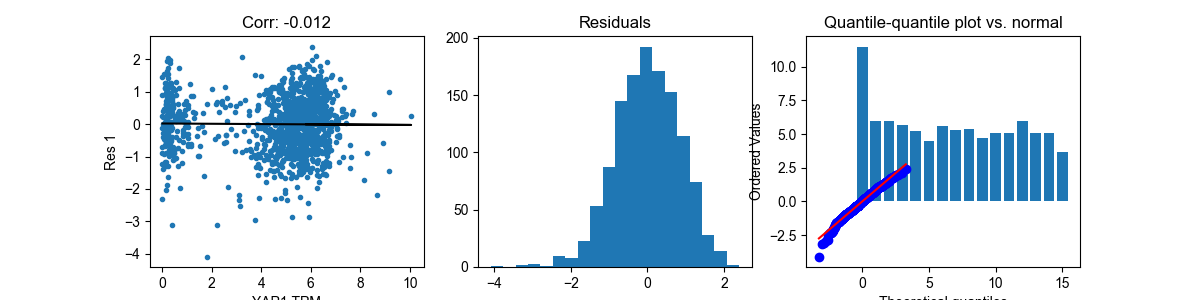

In [32]:
res2 = scatter(ccle_df, 'YAP1', res1, 'Res 1', bins=20)

Next steps:
1. load the INDRA SIF statement file
2. tabulate explanations for correlations;
3. predict correlations from graph structure, edge properties

In [34]:
from indra.util import batch_iter

In [37]:
goi = 'MDM2'
res = sort_corrs(dep_z, goi)
#for r in res[0:20]:
#    print(r)
expl_pct = []
batch_size = 1000
for batch in batch_iter(res, batch_size):
    counter = 0
    for gene, corr in batch:
        if gene in indra_dg[goi]:
            counter += 1
    pct = 100 * (counter / batch_size)
    expl_pct.append(pct)

<IPython.core.display.Javascript object>


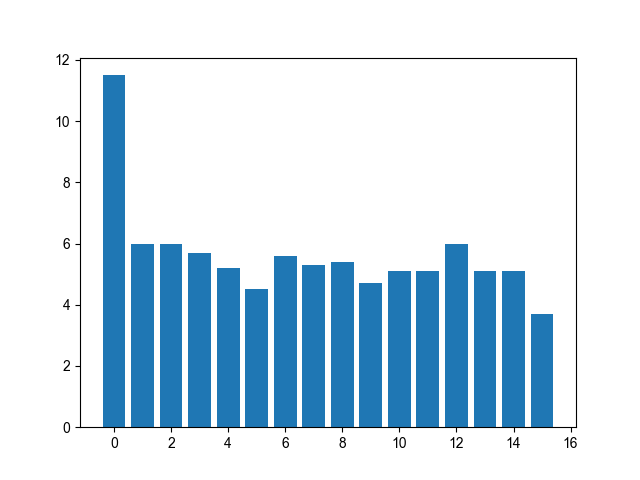

<BarContainer object of 16 artists>

In [39]:
plt.figure()
plt.bar(range(len(expl_pct)), expl_pct)

# Drug-Drug Correlations

In [40]:
drug2_corrs = drug_resp_df.corr()

In [49]:
from indra.sources import tas
tp = tas.process_from_web()

INFO: [2020-08-04 12:49:02] indra.sources.tas.api - Downloading TAS data from https://bigmech.s3.amazonaws.com/indra-db/tas.csv
INFO: [2020-08-04 12:49:11] indra.sources.tas.api - Verifying md5 checksum of data
INFO: [2020-08-04 12:49:11] indra.sources.tas.api - Finished downloading TAS data from https://bigmech.s3.amazonaws.com/indra-db/tas.csv
INFO: [2020-08-04 12:49:19] indra.ontology.bio.ontology - Loading INDRA bio ontology from cache at /Users/johnbachman/.indra/bio_ontology/1.2/bio_ontology.pkl


In [50]:
tas_stmts = tp.statements

In [106]:
# Build up a dictionary of mappings from CHEBI to SMILES and INCHIKEY
import pyobo
chebi_inchikey_property = 'http://purl.obolibrary.org/obo/chebi/inchikey'
chebi_smiles_property = 'http://purl.obolibrary.org/obo/chebi/smiles'
chebi_id_to_smiles = pyobo.get_filtered_properties_mapping('chebi', chebi_smiles_property)
chebi_id_to_inchikey = pyobo.get_filtered_properties_mapping('chebi', chebi_inchikey_property)

INFO: [2020-08-06 11:10:11] pyobo.struct.struct - [chebi] extracting OBO using obonet
INFO: [2020-08-06 11:10:12] pyobo.struct.struct - [chebi] extracted 126000 references
INFO: [2020-08-06 11:10:12] pyobo.struct.struct - [chebi] extracted 10 typedefs
INFO: [2020-08-06 11:10:12] pyobo.struct.struct - [chebi] extracted 3 synonym typedefs
INFO: [2020-08-06 11:10:52] pyobo.struct.struct - [chebi] extracted 126000 terms


In [134]:
foo = [stmt for stmt in tas_stmts if stmt.agent_list()[0].name == 'vemurafenib']

In [135]:
foo[0]

Inhibition(vemurafenib(), ARAF())

In [136]:
foo[0].subj.db_refs

{'LSPCI': '88284',
 'HMS-LINCS': '10068',
 'CHEBI': 'CHEBI:63637',
 'PUBCHEM': '42611257',
 'CHEMBL': 'CHEMBL1229517',
 'MESH': 'D000077484',
 'LINCS': 'LSM-1068',
 'DRUGBANK': 'DB08881',
 'CAS': '918504-65-1'}

In [162]:
chembl_ids = [stmt.agent_list()[0].db_refs.get('CHEMBL') for stmt in tas_stmts]
chembl_ids = list(set([i for i in chembl_ids if i]))

In [197]:
len(chembl_ids)

275346

In [219]:
chembl_ids_str = ';'.join(chembl_ids[0:200])

In [246]:
j = res.json()

In [251]:
j['molecules'][0]['molecule_chembl_id']

'CHEMBL1229517'

In [228]:
import requests
from indra.util import batch_iter
batch_size = 200
chembl_url = 'https://www.ebi.ac.uk/chembl/api/data/molecule/set/'
inchi_keys = []
for ix, batch in enumerate(batch_iter(chembl_ids, batch_size)):
    chembl_ids_str = ';'.join(list(batch))
    print(ix)
    res = requests.get(chembl_url + chembl_ids_str, headers={'Accept': 'application/json'})
    if res.status_code != 200:
        print("Error occurred")
        break
    for mol in j['molecules']:
        cid = mol['molecule_chembl_id']
        ik = mol['molecule_structures']['standard_inchi_key']
        inchi_keys.append((cid, ik))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [239]:
j = res.json()

In [237]:
inchi_to_chembl = {t[1]: t[0] for t in inchi_keys}
chembl_to_inchi = {t[0]: t[1] for t in inchi_keys}

In [41]:
def get_drug_id(name):
    drug_rec = drug_info_df[drug_info_df.name == name]
    return drug_rec.index.to_list()[0]

def get_drug_name(drug_id):
    drug_rec = drug_info_df.loc[drug_id]
    return drug_rec['name']

def get_drug_targets(drug_id):
    drug_rec = drug_info_df.loc[drug_id]
    targets = drug_rec['target']
    if pd.isna(targets):
        return []
    else:
        return [t.strip() for t in targets.split(',')]

In [101]:
# Dump all smiles strings from the DepMap data
depmap_smiles = set()
for _, smiles_str in drug_info_df.smiles.items():
    if pd.isna(smiles_str):
        continue
    for sm in smiles_str.split(','):
        sm = sm.strip()
        if sm:
            depmap_smiles.add(sm.strip())
            
depmap_smiles = list(demap_smiles)

with open('depmap_smiles.txt', 'wt') as f:
    for sm in depmap_smiles:
        f.write('%s\n' % sm)

In [109]:
# Convert from SMILES to INCHIKEY using obabel:
# $ obabel -ismi depmap_smiles.txt -oinchikey > depmap_inchikey.txt

In [112]:
# Now, read the INCHIKEY databack in and build up a mapping dictionary
depmap_inchikey = []
with open('depmap_inchikey.txt', 'rt') as f:
    depmap_inchikey = [l.strip() for l in f.readlines()]
depmap_smiles_to_ik = dict(zip(depmap_smiles, depmap_inchikey))

In [252]:
import requests
from indra.util import batch_iter
chembl_url = 'https://www.ebi.ac.uk/chembl/api/data/substructure/'
dmik_to_chembl = {}
for ix, ik in enumerate(depmap_smiles_to_ik.values()):
    if ix > 10:
        break
    res = requests.get(chembl_url + ik, headers={'Accept': 'application/json'})
    if res.status_code != 200:
        print("Error occurred")
        break
    if res.json()['molecules']:
        for mol in res.json()['molecules']:
            cid = mol['molecule_chembl_id']
            if ik not in dmik_to_chembl:
                dmik_to_chembl[ik] = [cid]
            else:
                dmik_to_chembl[ik].append(cid)

In [253]:
dmik_to_chembl

{'DKJJVAGXPKPDRL-UHFFFAOYSA-N': ['CHEMBL1350', 'CHEMBL1200448'],
 'PDOCBJADCWMDGL-UHFFFAOYSA-N': ['CHEMBL28854'],
 'SJYFDORQYYEJLB-UHFFFAOYSA-N': ['CHEMBL1433455', 'CHEMBL1742440'],
 'RKZSNTNMEFVBDT-MRVPVSSYSA-N': ['CHEMBL419792',
  'CHEMBL3797740',
  'CHEMBL3800633',
  'CHEMBL3798179',
  'CHEMBL3799626',
  'CHEMBL4096422'],
 'QUCQEUCGKKTEBI-UHFFFAOYSA-N': ['CHEMBL274189',
  'CHEMBL206106',
  'CHEMBL378822',
  'CHEMBL391209',
  'CHEMBL232454',
  'CHEMBL441917',
  'CHEMBL510114',
  'CHEMBL454377',
  'CHEMBL457070',
  'CHEMBL574904',
  'CHEMBL1182356',
  'CHEMBL1185134',
  'CHEMBL1185929',
  'CHEMBL1186210',
  'CHEMBL1186281',
  'CHEMBL1197514',
  'CHEMBL1270849',
  'CHEMBL2160113',
  'CHEMBL2160114',
  'CHEMBL2163795'],
 'JCHAWRDHMUSLMM-UPHRSURJSA-N': ['CHEMBL4303237'],
 'PSIFNNKUMBGKDQ-UHFFFAOYSA-N': ['CHEMBL907',
  'CHEMBL995',
  'CHEMBL82445',
  'CHEMBL87343',
  'CHEMBL446373',
  'CHEMBL367465',
  'CHEMBL360220',
  'CHEMBL186572',
  'CHEMBL203994',
  'CHEMBL380969',
  'CHEMBL445400',

In [42]:
drug_name = 'vemurafenib'

In [76]:
drug_info_df[drug_info_df['name'] == 'vemurafenib']

,broad_id,name,dose,screen_id,moa,target,disease.area,indication,smiles,phase
column_name,,,,,,,,,,
BRD-K56343971-001-10-6::2.5::HTS,BRD-K56343971-001-10-6,vemurafenib,2.5,HTS,RAF inhibitor,"BRAF, RAF1",oncology,melanoma,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(cc23)...,Launched


In [232]:
sm = [s.strip() for s in drug_info_df[drug_info_df['name'] == 'vemurafenib']['smiles'].values[0].split(',')]

In [233]:
sm

['CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(cc23)-c2ccc(Cl)cc2)c1F',
 'CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(cc23)-c2ccc(Cl)cc2)c1F',
 'CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(cc23)-c2ccc(Cl)cc2)c1F']

In [243]:
for s in sm:
    ik = depmap_smiles_to_ik[s]
    print(ik)

GPXBXXGIAQBQNI-UHFFFAOYSA-N
GPXBXXGIAQBQNI-UHFFFAOYSA-N
GPXBXXGIAQBQNI-UHFFFAOYSA-N


In [238]:
chembl_to_inchi['CHEMBL1229517']

KeyError: 'CHEMBL1229517'

In [256]:
drug_name = 'abemaciclib'
corrs = sort_corrs(drug2_corrs, get_drug_id(drug_name))
results = []
corr_k = 20
for i, (corr_drug_id, corr_val) in enumerate(corrs):
    if corr_val == 1.0:
        continue
    if i >= corr_k:
        break
    corr_drug_name = get_drug_name(corr_drug_id)
    corr_targets = get_drug_targets(corr_drug_id)
    for t in corr_targets:
        results.append((corr_drug_name, corr_drug_id, corr_val, t))
tgt_df = pd.DataFrame.from_records(results, columns=('drug_name', 'drug_id', 'corr', 'target'))

In [261]:
tgt_df

,drug_name,drug_id,corr,target
0,pacritinib,BRD-K19034817-001-01-4::2.5::HTS,0.596302,FLT3
1,pacritinib,BRD-K19034817-001-01-4::2.5::HTS,0.596302,JAK1
2,pacritinib,BRD-K19034817-001-01-4::2.5::HTS,0.596302,JAK2
3,pacritinib,BRD-K19034817-001-01-4::2.5::HTS,0.596302,JAK3
4,palbociclib,BRD-K51313569-003-03-3::2.5::HTS,0.480986,CDK4
5,palbociclib,BRD-K51313569-003-03-3::2.5::HTS,0.480986,CDK6
6,cyt387,BRD-K87737963-001-06-0::2.5::HTS,0.446616,JAK1
7,cyt387,BRD-K87737963-001-06-0::2.5::HTS,0.446616,JAK2
8,cyt387,BRD-K87737963-001-06-0::2.5::HTS,0.446616,JAK3
9,defactinib,BRD-K43578482-001-01-4::2.5::HTS,0.431801,PTK2


In [258]:
tgt_df

,drug_name,drug_id,corr,target
0,pacritinib,BRD-K19034817-001-01-4::2.5::HTS,0.596302,FLT3
1,pacritinib,BRD-K19034817-001-01-4::2.5::HTS,0.596302,JAK1
2,pacritinib,BRD-K19034817-001-01-4::2.5::HTS,0.596302,JAK2
3,pacritinib,BRD-K19034817-001-01-4::2.5::HTS,0.596302,JAK3
4,palbociclib,BRD-K51313569-003-03-3::2.5::HTS,0.480986,CDK4
5,palbociclib,BRD-K51313569-003-03-3::2.5::HTS,0.480986,CDK6
6,cyt387,BRD-K87737963-001-06-0::2.5::HTS,0.446616,JAK1
7,cyt387,BRD-K87737963-001-06-0::2.5::HTS,0.446616,JAK2
8,cyt387,BRD-K87737963-001-06-0::2.5::HTS,0.446616,JAK3
9,defactinib,BRD-K43578482-001-01-4::2.5::HTS,0.431801,PTK2


In [46]:
tgt_corrs = tgt_df.groupby('target')['corr'].sum()
tgt_counts = tgt_df.groupby('target')['drug_id'].count()
tgt_corrs.sort_values(ascending=False, inplace=True)
tgt_counts.sort_values(ascending=False, inplace=True)

In [47]:
num_tgts = 20
top_corrs = tgt_corrs[0:num_tgts]
labels = top_corrs.index.to_list()
corrs = top_corrs.values

<IPython.core.display.Javascript object>


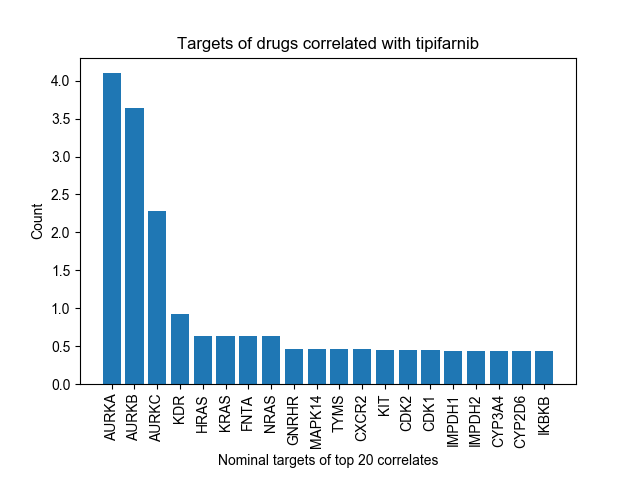

In [48]:
plt.figure()
plt.bar(range(len(corrs)), corrs, align='center', tick_label=labels)
plt.xticks(rotation='vertical')
plt.subplots_adjust(bottom=0.2)
plt.xlabel('Nominal targets of top %d correlates' % corr_k)
plt.ylabel('Count')
plt.title('Targets of drugs correlated with %s' % drug_name)
plt.show()

# Depmap Paper Figures

## Figure 1: Example correlation

6.629088450045545

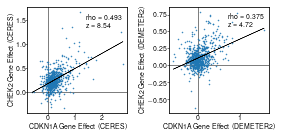

In [249]:
from indra.util import plot_formatting as pf
from scipy.stats import linregress

pf.set_fig_params()
geneA = 'CDKN1A'
geneB = 'CHEK2'
lw = 0.5
ms = 1
fig = plt.figure(figsize=(4, 2))
# CRISPR plot
plt.subplot(1, 2, 1)
ax = plt.gca()
ax.axhline(y=0, color='k', linewidth=lw)
ax.axvline(x=0, color='k', linewidth=lw)
plt.plot(crispr_df[geneA].values, crispr_df[geneB].values, marker='.', markersize=ms, linestyle='')
# Plot linear regression
crispr_lr = linregress(crispr_df[geneA].values, crispr_df[geneB].values)
plt.plot(crispr_df[geneA].values, crispr_df[geneA].values * crispr_lr.slope + crispr_lr.intercept,
         linestyle='-', linewidth=lw, color='black')
plt.xlabel(f'{geneA} Gene Effect (CERES)')
plt.ylabel(f'{geneB} Gene Effect (CERES)')
ax.text(1.4, 1.5, 'rho = %0.3f' % crispr_lr.rvalue, fontsize=pf.fontsize)
ax.text(1.4, 1.35, 'z = %0.2f' % crispr_z[geneA][geneB], fontsize=pf.fontsize)
pf.format_axis(ax)
# RNAi plot
plt.subplot(1, 2, 2)
rnai_df_filt = rnai_df[~pd.isnull(rnai_df[geneA]) & ~pd.isnull(rnai_df[geneB])]
ax = plt.gca()
ax.axhline(y=0, color='k', linewidth=lw)
ax.axvline(x=0, color='k', linewidth=lw)
plt.plot(rnai_df_filt[geneA].values, rnai_df_filt[geneB].values, marker='.', markersize=ms, linestyle='')
# Plot linear regression
rnai_lr = linregress(rnai_df_filt[geneA].values, rnai_df_filt[geneB].values)
plt.plot(rnai_df_filt[geneA].values, rnai_df_filt[geneA].values * rnai_lr.slope + rnai_lr.intercept,
         linestyle='-', linewidth=lw, color='black')
plt.xlabel(f'{geneA} Gene Effect (DEMETER2)')
plt.ylabel(f'{geneB} Gene Effect (DEMETER2)')
ax.text(0.7, 0.69, 'rho = %0.3f' % rnai_lr.rvalue, fontsize=pf.fontsize)
ax.text(0.7, 0.57, 'z = %0.2f' % rnai_z[geneA][geneB], fontsize=pf.fontsize)

pf.format_axis(ax)
fig.tight_layout()
plt.savefig(join(figdir, f'{geneA}_{geneB}_corr_plot.pdf'))
dep_z[geneA][geneB]

## Figure 2: Stronger Effects -> Stronger Correlations, Mito genes

In [ ]:
mitocarta = pd.read_excel('data/Human.MitoCarta2.0.xls', sheet_name=1)
mitogenes = list(mitocarta.Symbol.values)

In [234]:
crispr_mean = crispr_df.abs().mean(axis=0).sort_values()

In [235]:
crispr_z_mean = crispr_z.abs().mean(axis=0)

In [22]:
n_corrs = 100
np.mean(sorted(crispr_z['CHEK2'].abs(), reverse=True)[1:n_corrs+1])

4.797534488429607

In [23]:
#crispr_z_mean = crispr_z.apply(lambda x: np.mean(sorted(x.abs(), reverse=True)[1:101]), axis=1)

In [236]:
crispr_z_mean.CHEK2

0.9878772491747243

In [237]:
effect_corr = pd.concat([crispr_mean, crispr_z_mean], axis=1, sort=False)

In [238]:
mito_effect = effect_corr[effect_corr.index.isin(mitogenes)]
nonmito_effect = effect_corr[~effect_corr.index.isin(mitogenes)]

In [239]:
res = nonmito_effect.groupby(pd.qcut(nonmito_effect[0].values, 400)).mean()

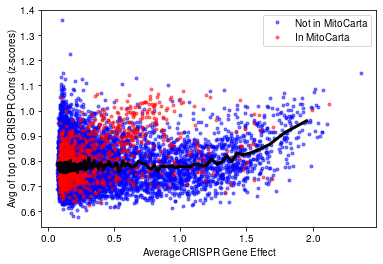

In [240]:
plt.plot(nonmito_effect[0], nonmito_effect[1], linestyle='', marker='.', color='b', alpha=0.5, label='Not in MitoCarta')
plt.plot(mito_effect[0], mito_effect[1], linestyle='', marker='.', color='r', alpha=0.5, label='In MitoCarta')
plt.plot(res[0].values, res[1].values, linewidth=3, color='black')
plt.xlabel('Average CRISPR Gene Effect')
plt.ylabel(f'Avg of top {n_corrs} CRISPR Corrs (z-scores)')
plt.legend()

## Clustering Correlation Data

In [26]:
dep_z.columns

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS',
       'AADAC', 'AADACL2',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=15746)

# Deprecated/Old

## Load Cosmic Data

In [ ]:
cos_df = pd.read_csv('data/Census_allThu Jun 13 20_37_30 2019.csv')

In [ ]:
cos_df.head()

In [ ]:
cos_corrs = corrs_for_genes(cos_df['Gene Symbol'])

## Load Solute Carrier Family genes

In [ ]:
slc_df = pd.read_csv('data/slc_genes.csv')

In [ ]:
slc_df.head()
slc_corrs = corrs_for_genes(slc_df['Approved symbol'])

In [ ]:
slc_corrs

In [ ]:
import requests

In [ ]:
query = {'source': None,
         'target': None,
         'stmt_filter': ['conversion', 'fplx'],
         'node_filter': ['hgnc', 'fplx', 'chebi', 'pubchem', 'go', 'mesh'],
         'node_blacklist': [],
         'edge_hash_blacklist': [],
         'path_length': 1,
         'sign': 'no_sign',
         'weighted': False,
         'bsco': 0.,
         'direct_only': False,
         'curated_db_only': False,         
         'fplx_expand': False,
         'simple': False,
         'k_shortest': False}

def get_expl_corrs(gene_pairs):
    no_path = []
    has_2path = []
    has_3path = []
    for ix, (gene_a, gene_b, z_score) in enumerate(gene_pairs):
        for source, target in ((gene_a, gene_b), (gene_b, gene_a)):
            print("%d getting paths for %s, %s" % (ix, source, target))
            query['source'] = source
            query['target'] = target
            query['path_length'] = 1
            res = requests.post('http://127.0.0.1:5000/query/submit', json=query).json()
            if '2' in res['result']['paths_by_node_count']:
                has_2path.append((source, target, z_score))
            else:
                query['path_length'] = 2
                res = requests.post('http://127.0.0.1:5000/query/submit', json=query).json()
                if '3' in res['result']['paths_by_node_count']:
                    has_3path.append((source, target, z_score))                
                else:
                    no_path.append((source, target, z_score))
    return {'no_path': no_path, 'has_2path': has_2path, 'has_3path': has_3path}

In [ ]:
paths = get_expl_corrs(sorted(slc_corrs, key=lambda x: x[2], reverse=True))

In [ ]:
paths['has_2path']

In [ ]:
paths['has_3path']

In [ ]:
paths['no_path']

In [ ]:
query['source'] = 'GRSF1'
query['target'] = 'SLC30A9'
query['path_length'] = 2
res = requests.post('http://127.0.0.1:5000/query/submit', json=query).json()

In [ ]:
res

## Load INDRA SIF DB

In [ ]:
stmts_df = pd.read_csv('data/stmts_by_pair_type.csv')
# Filter to HGNC only
stmts_df = stmts_df[(stmts_df['agA_ns'] == 'HGNC') & (stmts_df['agB_ns'] == 'HGNC')]
# Remove namespace and identifier columns, leaving only name
stmts_df = stmts_df[['agA_name', 'agB_name', 'stmt_type', 'evidence_count']]
# Remove self-edges
stmts_df = stmts_df[stmts_df['agA_name'] != stmts_df['agB_name']]
# Useful bits of Pandas to know, ultimately not used here:
# pd.crosstab([foo['agA_name'], foo['agB_name']], foo['stmt_type'], foo['evidence_count'],
#             aggfunc='sum', dropna=False).fillna(0)
# baz = bar[bar.apply(lambda x: x.name[0] != x.name[1], axis=1)]

In [ ]:
x_dict = {}
for row in stmts_df.values:
    try:
        raw_corr = dep_z[row[0]][row[1]]
        """
        if int(raw_corr) == 0:
            corr = 0
        elif int(raw_corr) < 0:
            corr = -1
        elif int(raw_corr) > 0:
            corr = 1
        """
        corr = raw_corr
    except KeyError:
        continue
    stmt_type = row[2]
    gene_pair = (row[0], row[1])
    if gene_pair not in x_dict:
        x_dict[gene_pair] = {'Corr': corr}
    x_dict[gene_pair][stmt_type] = row[3]
features = ['Activation', 'Inhibition', 'Corr']
all_data = np.zeros((len(x_dict), len(features)))
for row_ix, feat_dict in enumerate(x_dict.values()):
    for feat_name, feat_val in feat_dict.items():
        if feat_name not in features:
            continue
        feat_ix = features.index(feat_name)
        all_data[row_ix, feat_ix] = feat_val

In [ ]:
"""
# Shuffle the matrix in place
np.random.shuffle(all_data)
# Balance the data
ctr = Counter(all_data[:, -1])
classes = sorted([(k, v) for k,  v in ctr.items()], key=lambda x: x[0])
# Get the class with the fewest members
min_class_count = min([t[1] for t in classes])
min_class_count
data_bal = np.zeros((min_class_count * len(classes), len(features)))
row_ix = 0
for one_class, count in classes:
    num_class_rows = 0
    for ix in range(all_data.shape[0]):
        if all_data[ix, -1] == one_class:
            data_bal[row_ix] = all_data[ix,:]
            row_ix += 1
            num_class_rows += 1
        if num_class_rows >= min_class_count:
            print("Finished class %s, at rows %s" % (one_class, row_ix))
            break

"""

In [ ]:
# Divide training and test
np.random.shuffle(all_data)
partition_ix = int(len(all_data) * 0.8)
train_data = all_data[0:partition_ix, :]
test_data = all_data[partition_ix:, :]
x_train = train_data[:,:-1]
y_train = train_data[:, -1]
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb.score(x_test, y_test)

In [ ]:
yctr = Counter(y_train)
yclasses = sorted([(k, v) for k,  v in yctr.items()], key=lambda x: x[0])

In [ ]:
[features + ['Count']] + list(zip(nb.coef_, classes))

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.kernel_ridge import KernelRidge
lr = LinearRegression()

In [ ]:
lr.fit(x_train, y_train)
lr.coef_

In [ ]:
y_pred = lr.predict(x_train)
explained_variance_score(y_train, y_pred)

In [ ]:
y_mean = np.full(y_train.shape, y_train.mean())
explained_variance_score(y_train, y_mean)

In [ ]:
y_pred_test = lr.predict(x_test)
explained_variance_score(y_test, y_pred_test)

## Load INDRA Statements (deprecated)

In [ ]:
reload = False
if reload:
    inc_stmts = ac.load_statements('increase_amt.pkl')
    dec_stmts = ac.load_statements('decrease_amt.pkl')
    stmts = inc_stmts + dec_stmts
    stmts = ac.map_grounding(stmts)
    stmts = [s for s in stmts if s.subj and s.subj.db_refs.get('HGNC')
                             and s.obj and s.obj.db_refs.get('HGNC')]
    stmts = ac.run_preassembly(stmts)
    ac.dump_statements(stmts, 'assembled_stmts.pkl')
else:
    stmts = ac.load_statements('assembled_stmts.pkl')

In [ ]:
stmts_by_obj = defaultdict(list)
for s in stmts:
    gene_id = s.obj.db_refs['HGNC']
    gene_name = hgnc_client.get_hgnc_name(gene_id)
    stmts_by_obj[gene_name].append(s)

In [ ]:
stmt_counts = []
for obj, stmts in stmts_by_obj.items():
    stmt_counts.append((obj, len(stmts)))
stmt_counts.sort(key=lambda x: x[1], reverse=True)

In [ ]:
stmt_counts[0:10]

In [ ]:
gene = 'BCL2'
rank = 0
stmts_by_obj[gene].sort(key=lambda s: s.belief, reverse=True)
print(stmts_by_obj[gene][rank], '\n')
print('\n'.join(['%d: %s\n' % (i, str((e.source_api, e.text)))
                 for i, e in enumerate(stmts_by_obj[gene][rank].evidence)]))